# Adaptive Multilook

In this tutorial, we demostrate how to use Moraine package to identify spatially homogeneous pixels, extimate the coherence matrix and compare the original interferogram, multilook intergerogram and the adaptive multilook interferogram.

In [ ]:
import numpy as np
import zarr
from matplotlib import pyplot as plt

from moraine.utils_ import is_cuda_available
if is_cuda_available():
    import cupy as cp
    from cupyx.scipy.ndimage import uniform_filter

import moraine as mr

## Load rslc stack

In [ ]:
if is_cuda_available():
    print(cp.cuda.Device(1).use())
    rslc = cp.asarray(zarr.open('../../data/rslc.zarr',mode='r')[:])
    print(rslc.shape)

<CUDA Device 1>
(2500, 1834, 17)


## Apply ks test

In [ ]:
%%time
if is_cuda_available():
    rmli = cp.abs(rslc)**2

    az_half_win = 5
    r_half_win = 5
    az_win = 2*az_half_win+1
    r_win = 2*r_half_win+1

    p = mr.ks_test(rmli,az_half_win=az_half_win,r_half_win=r_half_win)

CPU times: user 216 ms, sys: 65.8 ms, total: 282 ms
Wall time: 2.56 s


## Select SHPs

In [ ]:
if is_cuda_available():
    is_shp = (p < 0.05) & (p >= 0.0)

In [ ]:
if is_cuda_available():
    shp_num = cp.count_nonzero(is_shp,axis=(-2,-1))
    shp_num_np = cp.asnumpy(shp_num)

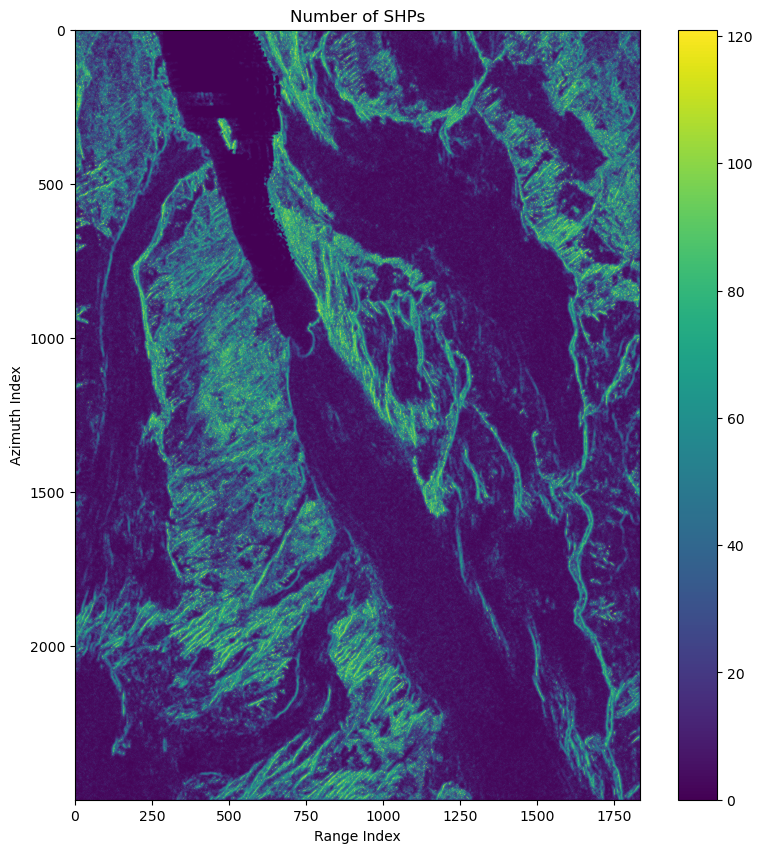

In [ ]:
if is_cuda_available():
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    pcm = ax.imshow(shp_num_np)
    ax.set(title='Number of SHPs',xlabel='Range Index',ylabel='Azimuth Index')
    fig.colorbar(pcm)
    fig.show()

## Estimate coherence matrix

In [ ]:
%%time
if is_cuda_available():
    coh = mr.emperical_co(rslc,is_shp)[1]

CPU times: user 127 ms, sys: 20.6 ms, total: 148 ms
Wall time: 151 ms


## Compare

Here we compare 1-look interferogram, multilook interferogram and adaptive multilook interferogram

In [ ]:
ref_image = 15
sec_image = 16

1 look interferogram:

In [ ]:
if is_cuda_available():
    diff = rslc[:,:,ref_image]*rslc[:,:,sec_image].conj()

Multilook interferogram:

In [ ]:
if is_cuda_available():
    ml_diff = uniform_filter(diff,size=(az_win,r_win))

Adaptive multilook interferogram:

In [ ]:
if is_cuda_available():
    ad_ml_diff = coh[:,:,ref_image,sec_image]

The plot background:

In [ ]:
if is_cuda_available():
    plot_bg = rmli[:,:,0]
    plot_bg = cp.asnumpy(plot_bg)
    plot_bg = np.nan_to_num(plot_bg)
    alpha = mr.bg_alpha(plot_bg)

Plot:

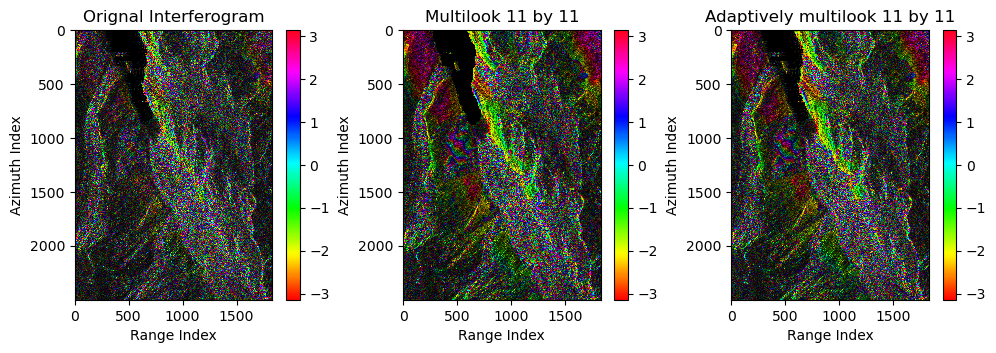

In [ ]:
if is_cuda_available():
    fig,axes = plt.subplots(1,3,figsize=(24/2,7/2))
    xlabel = 'Range Index'
    ylabel = 'Azimuth Index'
    pcm0 = axes[0].imshow(cp.asnumpy(cp.angle(diff)),alpha=alpha,interpolation='nearest',cmap='hsv')
    pcm1 = axes[1].imshow(cp.asnumpy(cp.angle(ml_diff)),alpha=alpha,interpolation='nearest',cmap='hsv')
    pcm2 = axes[2].imshow(cp.asnumpy(cp.angle(ad_ml_diff)),alpha=alpha,interpolation='nearest',cmap='hsv')
    for ax in axes:
        ax.set(facecolor = "black")
    axes[0].set(title='Orignal Interferogram',xlabel=xlabel,ylabel=ylabel)
    axes[1].set(title=f'Multilook {az_win} by {r_win}',xlabel=xlabel,ylabel=ylabel)
    axes[2].set(title=f'Adaptively multilook {az_win} by {r_win}',xlabel=xlabel,ylabel=ylabel)
    fig.colorbar(pcm0,ax=axes[0])
    fig.colorbar(pcm1,ax=axes[1])
    fig.colorbar(pcm1,ax=axes[2])
    fig.show()

## Conclusion

- Adaptive multilooking based on SHPs selection performs better than non-adaptive one;
- `ks_test` and `emperical_co` implemented in Moraine package are fast.